In [1]:
import os
import numpy as np
import pandas as pd
from astropy.table import Table

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod, rssMethod

ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")
MASTER_CON_LAMPS = {"b": "ldls", "r": "ldls", "z": "quartz"}
MASTER_ARC_LAMPS = {"b": "hgne", "r": "neon", "z": "neon"}
MASTER_ARC_LAMPS = {"b": "neon_hgne_argon_xenon", "r": "neon_hgne_argon_xenon", "z": "neon_hgne_argon_xenon"}

In [2]:
MJD = 60147
frames_table = md.get_metadata(tileid="*", mjd=MJD)
frames_table.query("imagetyp == 'bias' | imagetyp == 'dark' | imagetyp == 'flat' | imagetyp == 'arc'", inplace=True)

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60147/raw_metadata.hdf5
[INFO]: found 246 frames in store '/home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60147/raw_metadata.hdf5'
[INFO]: number of frames after filtering 246
[INFO]: total number of frames found 246


In [3]:
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, str(masters_mjd))
print(masters_path)

/home/mejia/Research/lvm/lvmdata/calib/60142


In [4]:
masters_flat = md.get_metadata(kind="master", imagetyp="flat").query("mjd == @MJD").sort_values("camera")
masters_flat

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5
[INFO]: found 102 frames in store '/home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/master_metadata.hdf5'
[INFO]: filtering by imagetyp = 'flat'
[INFO]: number of frames after filtering 18
[INFO]: total number of frames found 18


,tileid,mjd,rmjd,imagetyp,spec,camera,exptime,neon,hgne,krypton,...,argon,ldls,quartz,quality,qual,stage,status,drpqual,nframes,name
3,1111,60147,60147,flat,sp1,b1,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,4,lvm-mflat_ldls-b1
5,1111,60147,60147,flat,sp2,b2,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,4,lvm-mflat_ldls-b2
1,1111,60147,60147,flat,sp3,b3,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,4,lvm-mflat_ldls-b3
7,1111,60147,60147,flat,sp1,r1,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,4,lvm-mflat_ldls-r1
2,1111,60147,60147,flat,sp2,r2,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,4,lvm-mflat_ldls-r2
6,1111,60147,60147,flat,sp3,r3,150.0,False,False,False,...,False,True,False,excellent,0,1,0,0,4,lvm-mflat_ldls-r3
4,1111,60147,60147,flat,sp1,z1,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,4,lvm-mflat_quartz-z1
0,1111,60147,60147,flat,sp2,z2,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,4,lvm-mflat_quartz-z2
8,1111,60147,60147,flat,sp3,z3,10.0,False,False,False,...,False,False,True,excellent,0,1,0,0,4,lvm-mflat_quartz-z3


In [5]:
mtrace_paths = []
for flat in masters_flat.to_dict("records"):
    camera = flat["camera"]
    # define lamps for flats and arcs
    con_lamp = MASTER_CON_LAMPS[camera[0]]
    arc_lamp = MASTER_ARC_LAMPS[camera[0]]
    
    # define masters paths
    mflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=MJD, kind=f"mflat_{con_lamp}", camera=camera)
    mtrace_path = os.path.join(masters_path, f"lvm-mtrace-{camera}.fits")
    mwave_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
    mlsf_path = os.path.join(masters_path, f"lvm-mwave_{arc_lamp}-{camera}.fits")
    # define master fiberflat path
    wflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)

    imageMethod.extract_spectra(in_image=mflat_path, out_rss=wflat_path, in_trace=mtrace_path, method="aperture", aperture=3)
    rssMethod.create_pixel_table(in_rss=wflat_path, out_rss=wflat_path, arc_wave=mwave_path, arc_fwhm=mlsf_path)

[INFO]: reading continuum exposure from lvm-wmflat_ldls-b1.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-b2.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-b3.fits
[INFO]: caculating normalization in full wavelength range (3503.72 - 5992.24 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4080 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 2.5 angstroms (4 pixels)
[WARNING]: at fiber 1: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 109: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 289: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 325: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 397: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 414: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 462: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber

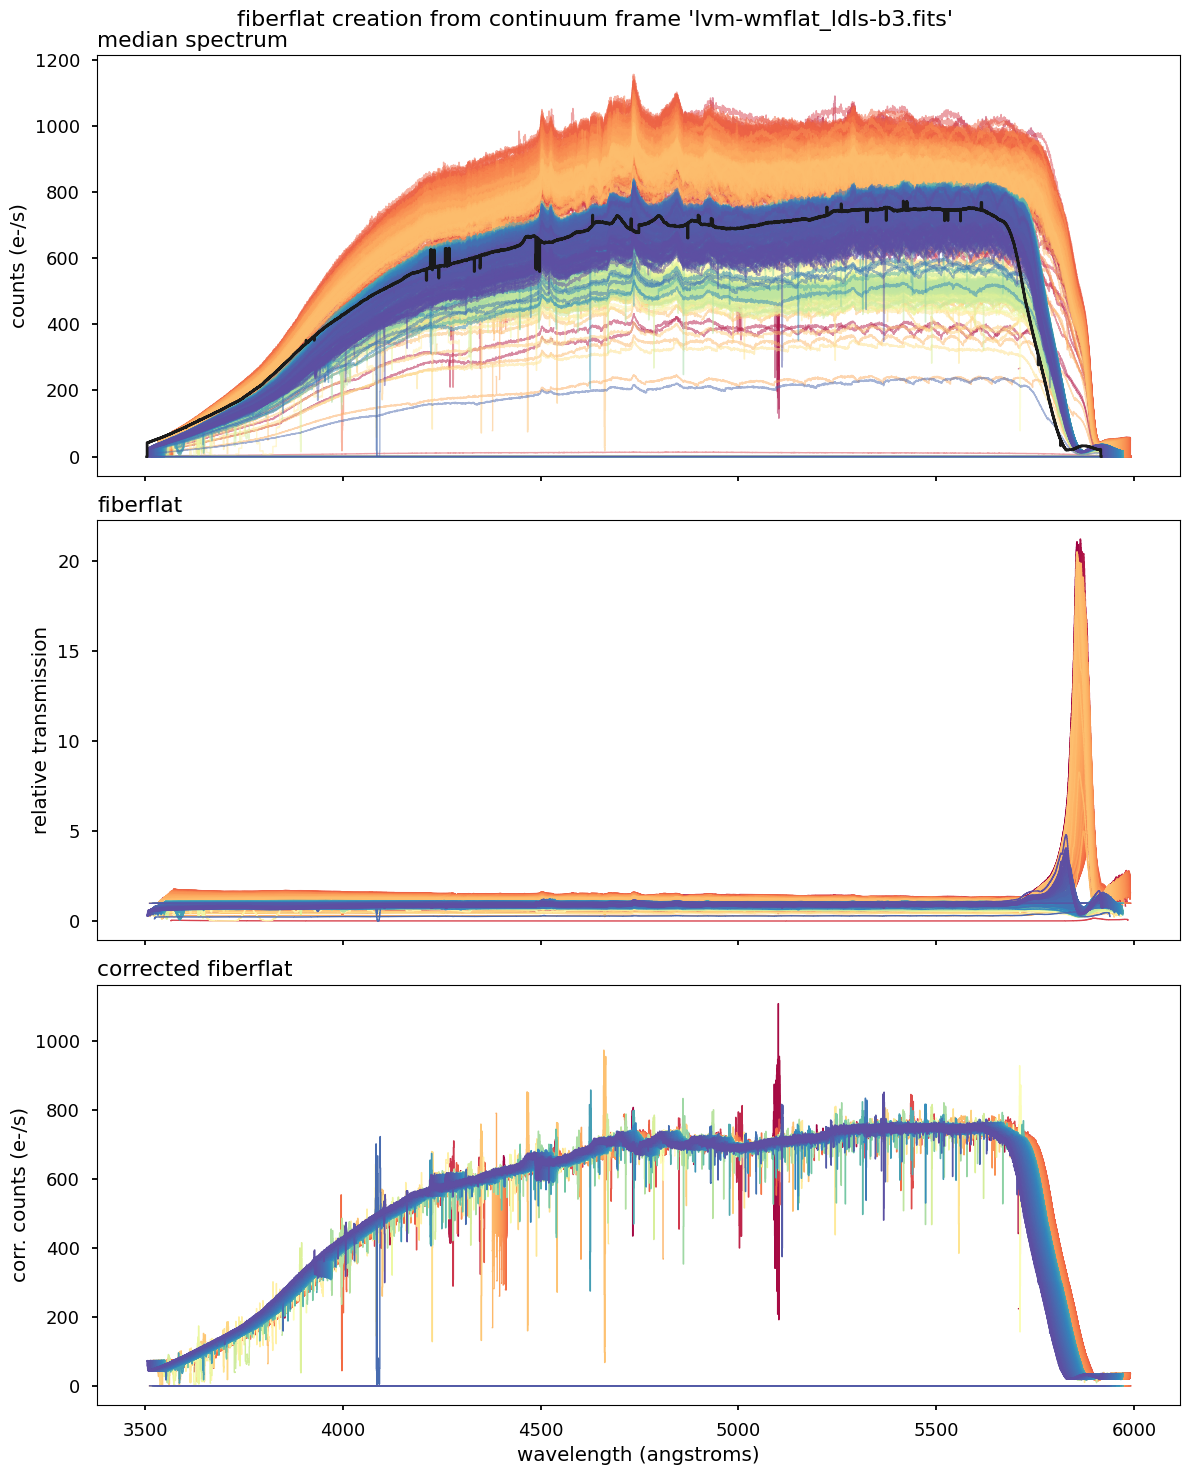

[INFO]: writing fiberflat to lvm-mfiberflat-b1.fits
[INFO]: fiberflat statistics: min = 0.013, max = 21.205, mean = 1.47, median = 1.31, std = 1.089
[INFO]: writing fiberflat to lvm-mfiberflat-b2.fits
[INFO]: fiberflat statistics: min = 0.020, max = 3.145, mean = 0.80, median = 0.78, std = 0.128
[INFO]: writing fiberflat to lvm-mfiberflat-b3.fits
[INFO]: fiberflat statistics: min = 0.005, max = 4.799, mean = 0.98, median = 1.00, std = 0.129
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r1.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r2.fits
[INFO]: reading continuum exposure from lvm-wmflat_ldls-r3.fits
[INFO]: caculating normalization in full wavelength range (5560.53 - 7791.34 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4080 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 2.5 angstroms (4 pixels)
[WARNING]: at fiber 1: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 109: cannot reshape array of

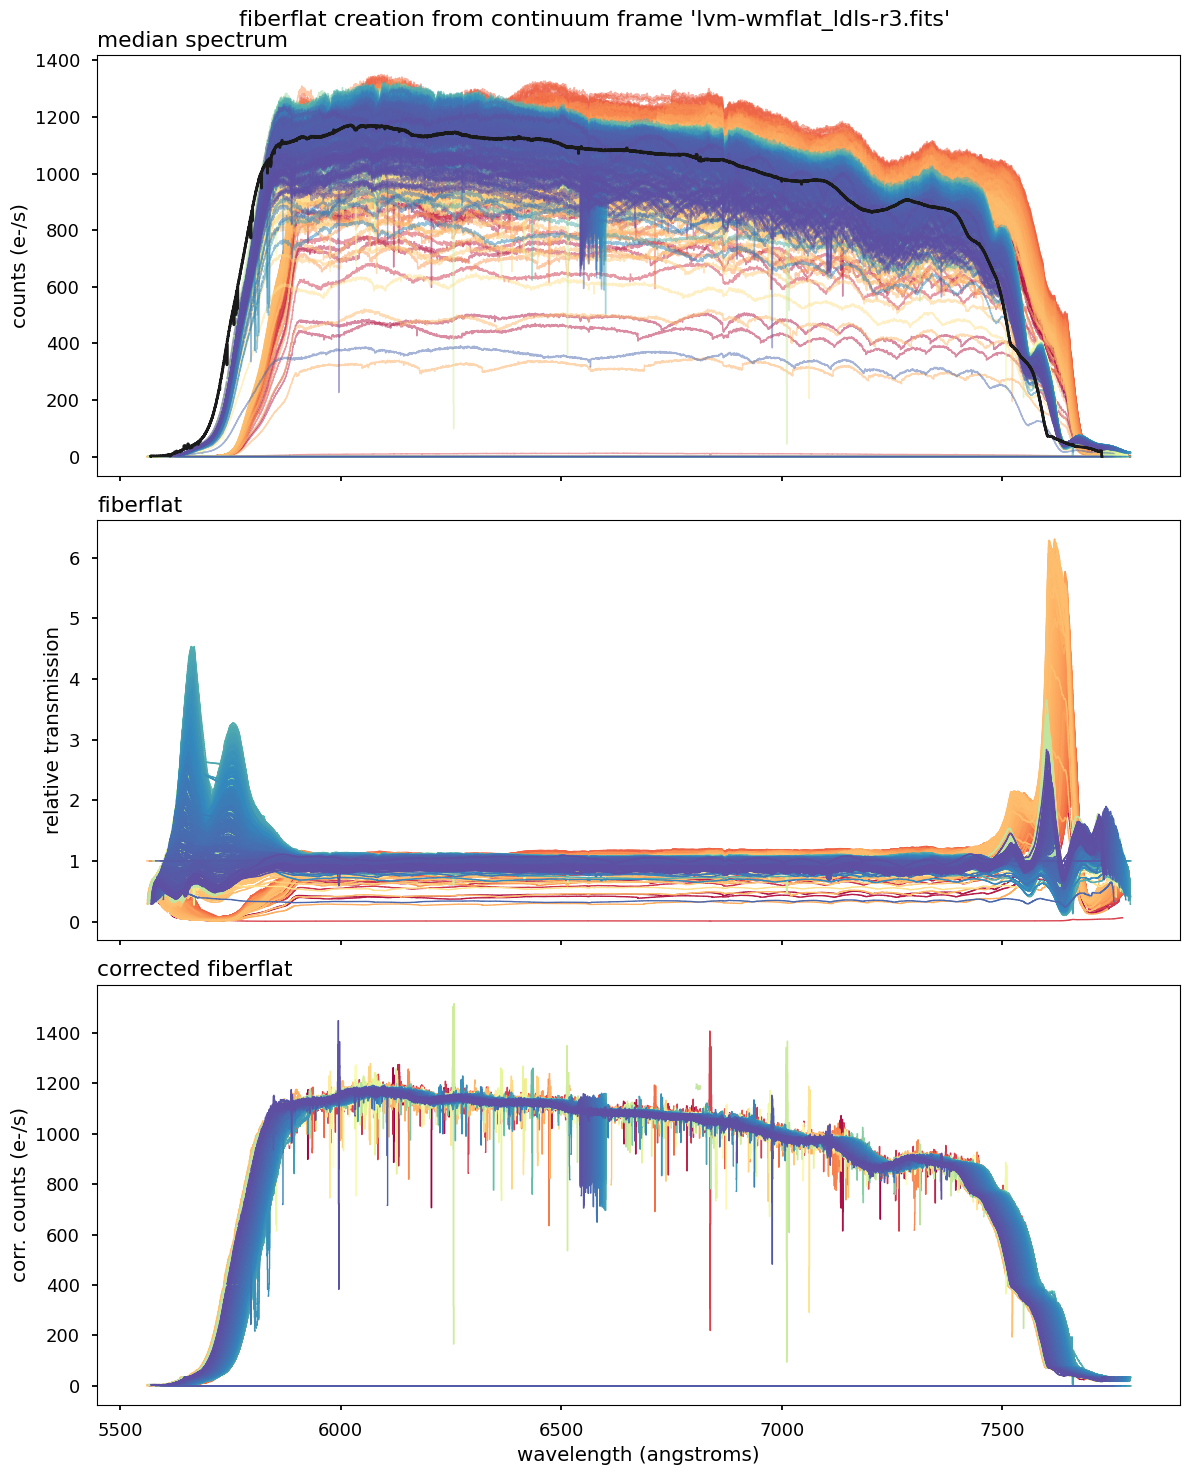

[INFO]: writing fiberflat to lvm-mfiberflat-r1.fits
[INFO]: fiberflat statistics: min = 0.005, max = 6.306, mean = 0.99, median = 1.02, std = 0.517
[INFO]: writing fiberflat to lvm-mfiberflat-r2.fits
[INFO]: fiberflat statistics: min = 0.129, max = 4.377, mean = 1.00, median = 0.97, std = 0.236
[INFO]: writing fiberflat to lvm-mfiberflat-r3.fits
[INFO]: fiberflat statistics: min = 0.100, max = 4.535, mean = 1.07, median = 1.02, std = 0.347
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z1.fits
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z2.fits
[INFO]: reading continuum exposure from lvm-wmflat_quartz-z3.fits
[INFO]: caculating normalization in full wavelength range (7346.15 - 9888.43 angstroms)
[INFO]: computing fiberflat across 1944 fibers and 4080 wavelength bins
[INFO]: applying gaussian smoothing with kernel size 2.5 angstroms (4 pixels)
[WARNING]: at fiber 1: cannot reshape array of size 0 into shape (0,newaxis)
[WARNING]: at fiber 109: cannot reshape arr

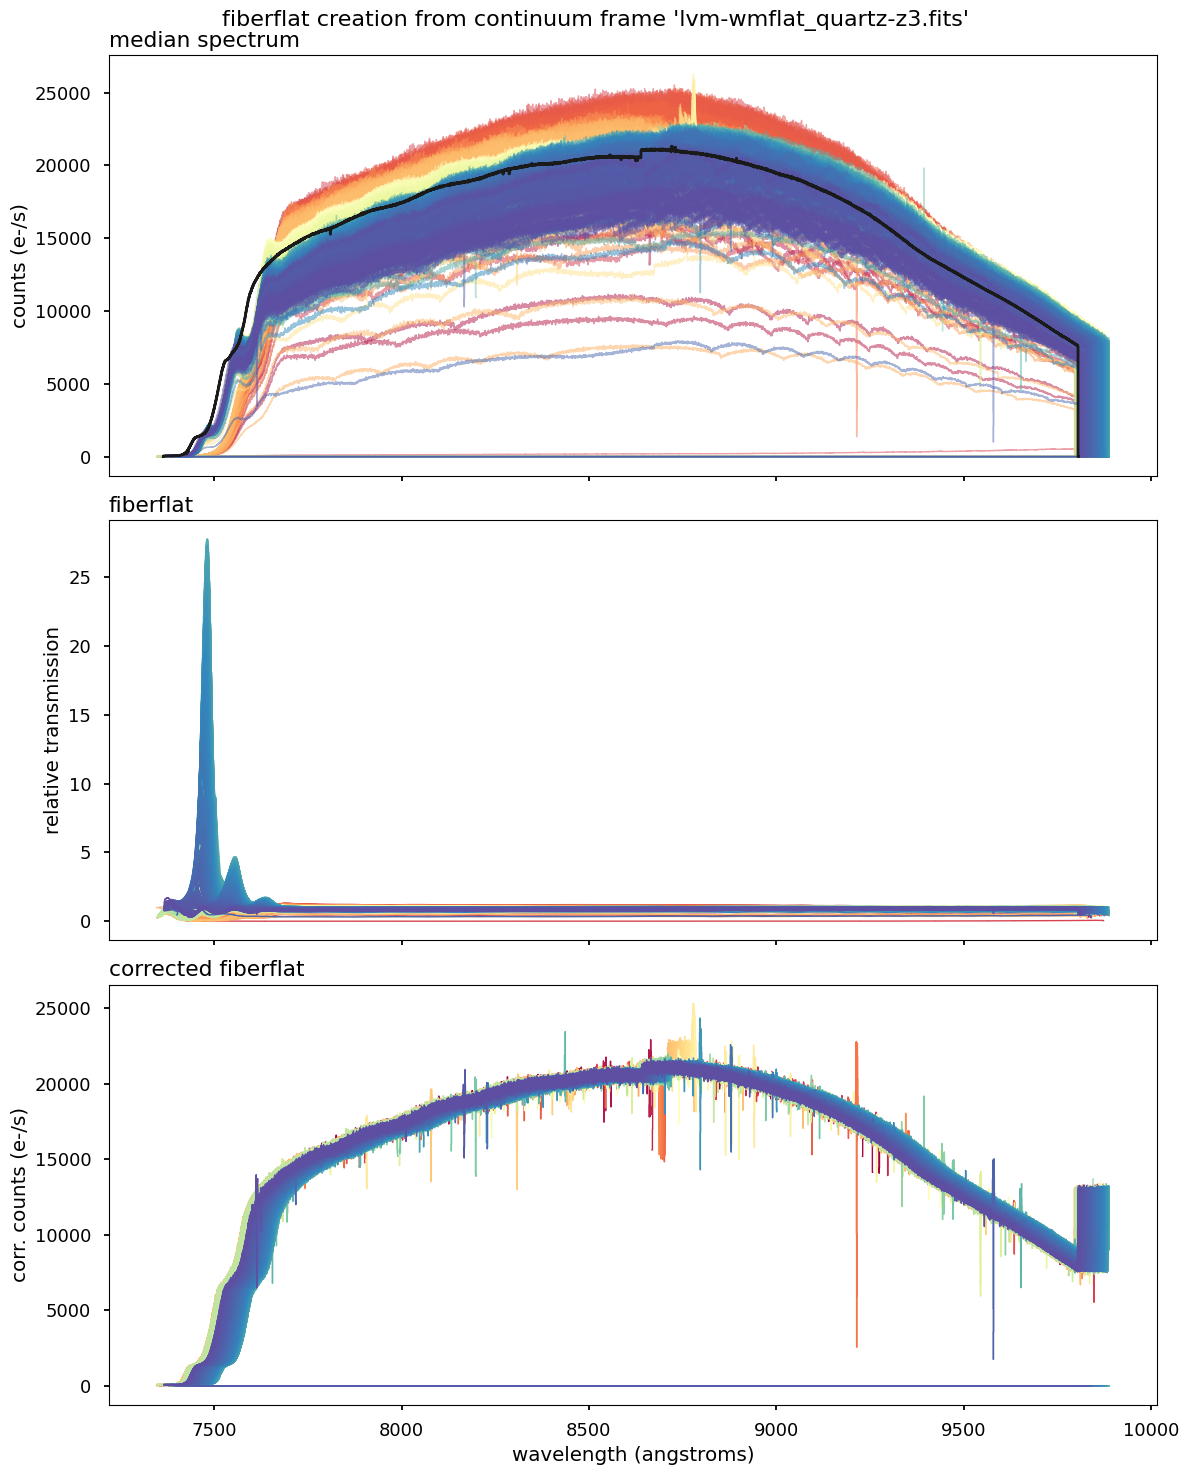

[INFO]: writing fiberflat to lvm-mfiberflat-z1.fits
[INFO]: fiberflat statistics: min = 0.007, max = 1.311, mean = 0.98, median = 1.03, std = 0.185
[INFO]: writing fiberflat to lvm-mfiberflat-z2.fits
[INFO]: fiberflat statistics: min = 0.054, max = 8.347, mean = 1.03, median = 1.00, std = 0.338
[INFO]: writing fiberflat to lvm-mfiberflat-z3.fits
[INFO]: fiberflat statistics: min = 0.260, max = 27.739, mean = 1.15, median = 0.99, std = 1.404
[INFO]: going to extract metadata from 3 frames
extracting metadata: 100%|##########| 3/3 [00:00<00:00, 267.73frame/s]
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60142/raw_metadata.hdf5
[INFO]: updating metadata store for tileid = 1111 and mjd = 60142 with 0 new rows
[INFO]: final number of rows 3
[INFO]: writing raw metadata store to disk
[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/data.sdss5.org/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/mas

In [6]:
for channel in "brz":
    wflat_paths, mfiberflat_paths = [], []
    for flat in masters_flat.to_dict("records"):
        camera = flat["camera"]
        if camera[0] != channel: continue
        con_lamp = MASTER_CON_LAMPS[camera[0]]
        wflat_path = path.full("lvm_master", drpver=drpver, tileid=flat["tileid"], mjd=MJD, kind=f"wmflat_{con_lamp}", camera=camera)
        mfiberflat_path = os.path.join(masters_path, f"lvm-mfiberflat-{camera}.fits")
        mfiberflat_paths.append(mfiberflat_path)
        wflat_paths.append(wflat_path)

    rssMethod.create_fiberflat(in_rsss=wflat_paths, out_rsss=mfiberflat_paths, median_box=0, gaussian_kernel=2.5, display_plots=True)

# cache new masters metadata into HDF5 files
new_masters = md.extract_metadata(frames_paths=mfiberflat_paths)
md.add_masters(new_masters)